In [162]:
import torch
import time  
import numpy as np 
from torch import nn, Tensor, optim
from torch.nn.parameter import Parameter 
from torch.optim.optimizer import Optimizer, required

from typing import List, Optional, Callable, Tuple

import libs.hij_tensor as pt
import libs.py_fock as fock
import libs.py_integral as integral

from vmc.PublicFunction import check_para, unit8_to_bit

In [163]:
def string_to_lst(sorb: int, string: str):
    arr = np.array(list(map(int, string)))[::-1]
    lst = [0] * ((sorb-1)//64 +1)*8
    for i in range((sorb-1)//8+1):
        begin = i * 8
        end = (i+1) * 8 if (i+1)*8 < sorb else sorb
        idx = arr[begin:end]
        lst[i] = np.sum(2**np.arange(len(idx)) * idx)

    return lst

chain_len = 2
integral_file = f"../integral/rmole-LiH-1.54.info"
int2e, int1e, ecore = integral.load(integral.two_body(), integral.one_body(), 0.0, integral_file)
print(ecore)
sorb = int2e.sorb
nele = 4
alpha_ele = nele//2 
beta_ele = nele//2
device = "cuda" if torch.cuda.is_available() else "cpu"
space = fock.get_fci_space(int(sorb//2), alpha_ele, beta_ele)
dim = len(space)

# h1e/h2e 
h1e = torch.tensor(int1e.data, dtype=torch.float64).to(device)
h2e = torch.tensor(int2e.data, dtype=torch.float64).to(device)

# bra/ket
lst = []
for i in range(dim):
    lst.append(string_to_lst(sorb, space[i].to_string()))
onstate1 = torch.tensor(lst, dtype=torch.uint8).to(device)
# onstate2 = torch.tensor(lst, dtype=torch.uint8).to(device)
print(onstate1.shape)

1.0255372304651162

integral::load fname = ../integral/rmole-LiH-1.54.info
sorb = 12
size(int1e) = 144:0.00109863MB:1.07288e-06GB
size(int2e) = 2277:0.0173721MB:1.6965e-05GB
----- TIMING FOR integral::load_integral : 0.000e+00 S -----
torch.Size([225, 8])


In [164]:
def setup_seed(x: int):
    torch.manual_seed(x)
    np.random.seed(x)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(x)
        torch.cuda.manual_seed_all(x)

In [165]:
class rRBMWavefunction(nn.Module):

    __constants__ = ['num_visible', 'num_hidden']
    num_visible: int 
    num_hidden: int 
    weights: Tensor

    def __init__(self, num_visible: int , num_hidden: int, device: str = None, init_weight=0.001) -> None:
        super(rRBMWavefunction, self).__init__()
        self.device = device 
        factory_kwargs = {'device': self.device, "dtype": torch.double}
        self.num_visible= num_visible
        self.num_hidden = num_hidden
        self.visible_bias = Parameter(init_weight * (torch.rand(self.num_visible, **factory_kwargs)- 0.5))
        self.hidden_bias = Parameter(init_weight * (torch.rand(self.num_hidden, **factory_kwargs)-0.5)) 
        self.weights = Parameter(init_weight * (torch.rand((self.num_hidden, self.num_visible), **factory_kwargs)-0.5))

        # self.init_para(**factory_kwargs)
        # self.visible_bias =  self.para[: self.num_visible] 
        # self.hidden_bias = self.para[self.num_visible: self.num_visible + self.num_hidden]
        # self.weights = self.para[self.num_visible + self.num_hidden:].reshape(self.num_hidden, -1)

    def init_para(self, **kwargs) -> None:
        n = self.num_visible + self.num_hidden + self.num_hidden * self.num_visible
        self.para = Parameter(torch.rand(n, **kwargs))

    def extra_repr(self) -> str:
        return f"RBMWavefunction: num_visible={self.num_visible}, num_hidden={self.num_hidden}"

    def _amplitude(self, x: Tensor) ->Tensor:
        return torch.einsum("j, ...j -> ...", self.visible_bias, x).exp()
    
    def _phase(self, x: Tensor) -> Tensor:
        return (2 * (torch.einsum("ij, ...j -> ...i", self.weights, x) + self.hidden_bias).cosh()).prod(-1)

    def forward(self, x) ->Tensor:
        out = self._amplitude(x) * self._phase(x)
        return out


In [166]:
def local_energy(x: Tensor, h1e: Tensor, h2e: Tensor, ansatz,
                 ecore: float,
                 sorb: int, nele: int,
                 verbose: bool = False) ->tuple[Tensor, Tensor]:
    """
    Calculate the local energy for given state.
    E_loc(x) = \sum_x' psi(x')/psi(x) * <x|H|x'> 
    1. the all Singles and Doubles excitation about given state using cpu:
        x: (1, sorb)/(batch, sorb) -> comb_x: (batch, ncomb, sorb)/(ncomb, sorb)
    2. matrix <x|H|x'> (1, ncomb)/(batch, ncomb)
    3. psi(x), psi(comb_x)[ncomb] using NAQS. 
    4. calculate the local energy
    """
    check_para(x)
    # TODO: "get_comb_tensor" in cuda 
    # TODO: python version x->comb_x

    device = x.device
    dim: int = x.dim()
    batch: int = x.shape[0]
    t0 = time.time_ns()
    comb_x = pt.get_comb_tensor(x.to("cpu"), sorb, nele, True).to(device)
    # calculate matrix <x|H|x'>
    delta0 = (time.time_ns()-t0)/1.0E06
    comb_hij = pt.get_hij_torch(x, comb_x, h1e, h2e, sorb, nele) # shape (1, n)/(batch, n)
    
    t1 =  time.time_ns()
    # TODO: time consuming
    x =  pt.unit8_to_bit(comb_x, sorb)
    delta1 = (time.time_ns()-t1)/1.0E06

    t2 = time.time_ns()
    psi_x1 = ansatz(x)
    torch.cuda.synchronize()
    delta2 = (time.time_ns()-t1)/1.0E06
    # print(rbm.phase(unit8_to_bit(comb_x, sorb))[1])
    # print(rbm.amplitude(unit8_to_bit(comb_x, sorb))[1])
    if dim == 2 and batch == 1:
        eloc = torch.sum(comb_hij * psi_x1 / psi_x1[..., 0]) # scalar
    elif dim == 2 and batch > 1:
        eloc = torch.sum(torch.div(psi_x1.T, psi_x1[..., 0]).T * comb_hij, -1) # (batch)

    if verbose:
        print(f"comb_x time: {delta0:.3f} ms, unit8_to_bit time: {delta1:.3f} ms, nqs time: {delta2:.3f} ms")
        
    return eloc, psi_x1[..., 0]

In [167]:
def total_energy(x: Tensor, nbatch: int, h1e: Tensor, h2e: Tensor, ansatz,
                ecore: float,
                sorb: int, nele: int, device: str="cuda", 
                sample_weights:Tensor = None) -> tuple[Tensor, Tensor]:
    
    dim: int = x.shape[0]
    eloc_lst = torch.zeros(dim, dtype=torch.float64).to(device)
    psi_lst = torch.zeros(dim, dtype=torch.float64).to(device)
    idx_lst = torch.arange(dim).to(device)

    # calculate the total energy using splits
    for ons, idx in zip(x.split(nbatch), idx_lst.split(nbatch)):
        t0 = time.time_ns()
        eloc_lst[idx], psi_lst[idx] =  local_energy(ons, h1e, h2e, ansatz, ecore, sorb, nele)
        delta = time.time_ns() - t0 
        print(f"batch Cost time: {delta/1.0E06:.3f} ms\n")

    print(eloc_lst)

    log_psi = psi_lst.log()
    if sample_weights is None:
        sample_weights = torch.ones(dim, dtype=torch.float64).to(device) 
        sample_weights /= sample_weights.sum()

    # gradients 2 * Real(Ep[(Eloc -Ep[Eloc]) * grad_thetaln(psi*)])
    eloc_corr = eloc_lst - (sample_weights * eloc_lst).sum(axis=0).detach()
    exp_op = 2 * (sample_weights * torch.matmul(eloc_corr, log_psi)).sum(axis=0) 

    # total energy 
    e_total = (eloc_lst * (psi_lst.pow(2)/(psi_lst.pow(2).sum()))).sum()

    return e_total, exp_op

In [168]:
import random
class MCMCSampler():
    """
    Generates samples of configurations from a neural quantum state(NQS)
    using Markov chain Monte Carlo(MCMC) algorithm
    """
    def __init__(self, nqs: Callable, initial_state: Tensor,
                 h1e: Tensor, h2e: Tensor,
                 ecore: float,
                 n_sample: int, sorb: int, nele: int, max_cycle: int = 2000,
                 verbose: bool = False, 
                 debug_exact: bool = False, full_space: Tensor = None
                 ) -> None:
        if debug_exact:
            assert full_space is not None, "full space must be given"
        self.debug = debug_exact
        self.nqs = nqs
        self.sorb = sorb
        self.nele = nele
        self.no = nele
        self.nv = sorb - nele
        self.eloc: Tensor = None
        self.verbose: bool = verbose
        self.h1e: Tensor = h1e
        self.h2e: Tensor = h2e
        self.ecore = ecore
        self.max_cycle = max_cycle 
        self.n_sample = n_sample
        self.n_accept = 0
        if self.n_sample < 50:
            raise ValueError(f"The number of sample{self.n_sample} should great 50")
        check_para(initial_state)
        # TODO: initial_state is unit8 or [-1, 1] bit ???
        self.current_state: Tensor = initial_state
        self.next_state: Tensor = initial_state
        if self.debug:
            self.state_sample: Tensor = full_space
        else:
            self.state_sample: Tensor = initial_state.repeat(self.n_sample, 1)


    def run(self, n_sweep: int = None) -> tuple[Tensor,Tensor]:
        if self.debug:
            self.eloc = local_energy(self.state_sample, self.h1e, self.h2e, 
                                 self.nqs, self.ecore, 
                                 self.sorb, self.nele, self.verbose)[0]
            return self.state_sample.detach(), self.eloc 
        if (n_sweep is None) or (n_sweep <= self.max_cycle + self.n_sample):
            n_sweep = self.max_cycle + self.n_sample
        # TODO: how to define the max of cycle 
        print('Starting MCMC Sampling')
        t0 = time.time_ns()
        prob_current = self.nqs(unit8_to_bit(self.current_state, self.sorb))**2
        spin_time = torch.zeros(n_sweep)
        for i in range(n_sweep):
            t1 = time.time_ns()
            # TODO: Time-consuming
            self.spin_flip_rand(self.next_state)
            psi = unit8_to_bit(self.next_state, self.sorb)
            spin_time[i] = (time.time_ns() - t1)/1.0E06
            prob_next = self.nqs(psi)**2
            prob_accept = min(1.00, (prob_next/prob_current).item())
            p = random.random()
            # print(f"random p {p:.3f}, prob_accept {prob_accept:.3f}")
            if p <= prob_accept:
                self.current_state = self.next_state.clone()
                prob_current = prob_next.clone()
                if i >= self.max_cycle:
                    self.n_accept += 1
                    
            if i >= self.max_cycle:
                self.state_sample[i-self.max_cycle] = self.current_state.clone()
        
        delta = time.time_ns() - t0
        print(f'Completed Monte Carlo Sampling {delta/1.0E09:.3f} s, acceptance ratio = {self.n_accept/self.n_sample:.3f}')
        print(f"spin flip average time: {spin_time.mean():.3f} ms, total time {spin_time.sum():.3f} ms")

        # calculate local energy
        self.eloc = local_energy(self.state_sample, self.h1e, self.h2e, 
                                 self.nqs, self.ecore, 
                                 self.sorb, self.nele, self.verbose)[0]
        
        return self.state_sample.detach(), self.eloc.detach()

    def spin_flip_rand(self, x: Tensor):
        olst, vlst = self.get_olst(x, self.sorb, self.nele)
        ia = torch.randint(self.no * self.nv, (1,))
        print(ia, olst, ia%self.no, vlst, ia//self.no)
        self._spin_flip(x, olst[ia%self.no])
        self._spin_flip(x, vlst[ia//self.nv])

    @staticmethod    
    def _spin_flip(x: Tensor, n: int):
        x[n//8] ^= (1<<(n%8)) # unit8

    @staticmethod
    def get_olst(x: Tensor, sorb, nele) ->tuple[Tensor, Tensor]:
        olst = []
        vlst = []
        device = x.device
        flag = True
        idx = 0
        bra = x.detach().clone()
        for i in range(len(x)):
            if flag:
                for _ in range(8):
                    if (bra[i] & 1 == 1):
                        olst.append(idx)
                    else:
                        vlst.append(idx)
                    bra[i] >>= 1
                    idx +=1
                    if idx >= sorb:
                        flag = False
                        break
            else:
                break
        olst_tensor = torch.tensor(olst, device=device)
        vlst_tensor = torch.tensor(vlst, device=device)

        return (olst, vlst)


In [169]:
def compute_derivs(derivs, Eloc, N_s, p):
    """Computes variational derivatives and update to params"""
    
    # print(sigmas)
    # theta = np.dot(weights.transpose(),
    #                sigmas.transpose()) + B  # n_h x N_s
    # dA = sigmas.transpose()  # n_spins x N_s
    # dB = np.tanh(theta)  # n_h x N_s
    # dW = sigmas.transpose().reshape((n_spins, 1, N_s)) * \
    #      np.tanh(theta.reshape((1, n_h, N_s)))
    # derivs = np.concatenate([dA, dB, dW.reshape(n_spins * n_h, N_s)])
   
    print(f"derivs shape {derivs.shape}")
    # print(f"N_s {N_s}")

    avg_derivs = np.sum(derivs, axis=1, keepdims=True) / N_s
    avg_derivs_mat = np.conjugate(avg_derivs.reshape(derivs.shape[0], 1))
    # print(np.allclose(
    #     avg_derivs_mat.real,
    #     avg_derivs.real
    # ))

    # print(avg_derivs_mat.shape)
    avg_derivs_mat = avg_derivs_mat * avg_derivs.reshape(
        1, derivs.shape[0]
    )
    # print(derivs.shape, avg_derivs.shape, avg_derivs_mat.shape)
    moment2 = np.einsum('ik,jk->ij', np.conjugate(derivs), derivs) / N_s
    # print(f"moment2: {moment2}")
    S_kk = np.subtract(moment2, avg_derivs_mat)
    # print(f"moment2 shape {moment2.shape}")
    # print(Eloc.shape)
    F_p = np.sum(Eloc.transpose() * np.conjugate(derivs), axis=1) / N_s
    F_p -= np.sum(Eloc.transpose(), axis=1) * \
           np.sum(np.conjugate(derivs), axis=1) / (N_s ** 2)
    S_kk2 = np.zeros(S_kk.shape, dtype=complex)
    row, col = np.diag_indices(S_kk.shape[0])
    S_kk2[row, col] =  np.diagonal(S_kk) * regular(p)
    S_reg = S_kk + S_kk2
    print(S_reg)
    update = np.dot(np.linalg.inv(S_reg), F_p).reshape(derivs.shape[0], 1)
    
    # print(f"S_reg shape {S_reg.shape}")
    # print(f"S_kk shape {S_kk.shape}")
    # print(f"F_p shape {F_p.shape}")
    # print(f"S_reg-1: {np.linalg.inv(S_reg).shape}")
    # print(f"update shape {update.shape}")
    # print(f"ssss {np.dot(np.linalg.inv(S_reg), F_p).shape}") 
    return update

def regular(p, l0=100, b=0.9, l_min=1e-4):
    """
    Lambda regularization parameter for S_kk matrix,
    see supplementary materials
    """

    return max(l0 * (b**p) , l_min)

In [170]:
def sr(eloc: Tensor, grad_total: Tensor, N_state: int, p: int) -> Tensor:


    avg_grad = torch.sum(grad_total, axis=0, keepdim=True)/N_state
    avg_grad_mat = torch.conj(avg_grad.reshape(-1, 1))
    avg_grad_mat = avg_grad_mat * avg_grad.reshape(1, -1)
    moment2 = torch.einsum("ki, kj->ij", torch.conj(grad_total), grad_total)/N_state
    S_kk = torch.subtract(moment2, avg_grad_mat)
    
    F_p = torch.sum(eloc.transpose(1, 0) * torch.conj(grad_total), axis=0)/N_state
    F_p -= torch.sum(eloc.transpose(1, 0), axis=0) * torch.sum(torch.conj(grad_total), axis=0)/(N_state**2)
    S_kk2 = torch.zeros_like(S_kk)
    row = torch.arange(S_kk.shape[0])
    S_kk2[row, row] = regular(p) * torch.diag(S_kk)
    S_reg = S_kk + S_kk2
    update = torch.matmul(torch.linalg.inv(S_reg), F_p).reshape(1, -1)
    return update

def calculate_sr_grad(params: List[Tensor], 
                      grad_save: List[Tensor], 
                      eloc: Tensor, 
                      N_state: int,
                      p: int, 
                      lr: float = 0.02):
    shape_lst = []
    grad_comb_lst = []
    n_para = len(grad_save[0])
    for i in range(n_para):
        shape_lst.append(grad_save[0][i].shape)
        comb = []
        for j in range(N_state):
            comb.append(grad_save[j][i].reshape(1, -1))
        grad_comb_lst.append(torch.cat(comb))
    
    param_group = list(params)
    for i in range(n_para):
        update = sr(eloc, grad_comb_lst[i], N_state, p)
        # print(grad_comb_lst[i].T.shape)
        # update1 = compute_derivs(grad_comb_lst[i].T.cpu().detach().numpy(), eloc.T.cpu().detach().numpy(), N_state, p)
        # print(np.allclose(
        #     update.detach().cpu().numpy(),
        #     update1.real.T
        # ))
        param_group[i].data.add_(update.reshape(shape_lst[i]), alpha=-lr)
        print(param_group[i].grad)

In [171]:
grad_lst = []
out_lst = []

def hook_fn_backward(model, grad_in, grad_out):
    lst = []
    for para in model.parameters():
        if para.grad is not None:
            lst.append(para.grad.detach().clone()/out_lst[-1])
    grad_lst.append(lst)
    del lst 

def hook_fn_forward(model, data_in, data_out):
    out_lst.append(data_out.detach().clone())

ecore = 0.00
# seed = 2000
# setup_seed(seed)
e_list =[]
model = rRBMWavefunction(sorb, sorb*2).to(device)
print(model)
x0 = onstate1[0]
time_sample = []
time_iter = []


with torch.no_grad():
    nbatch  = 4
    e, exp_op = total_energy(onstate1, nbatch, h1e, h2e, 
                                 model,ecore, sorb, nele, device=device)
    e_list.append(e.item())
print(f"begin e is {e}")

from vmc.optim import SR

n = 60
debug = False

opt = SR(model.parameters(), lr=0.01, N_state=onstate1.shape[0] if debug else n)

for p in range(1):
    grad_lst = []
    out_lst = []
    t0 = time.time_ns()
    sample = MCMCSampler(model, x0.detach(), h1e, h2e, ecore, n, sorb, nele, 
                        verbose=True, debug_exact=debug, full_space=onstate1)
    state, eloc = sample.run() # eloc [n_sample]
    print("state: ")
    print(state)
    print("local energy")
    print(eloc)
    n_sample = len(state)
    # TODO: cuda version unit8_to_bit 2D
    sample_state = unit8_to_bit(state, sorb)
    delta = (time.time_ns() - t0)/1.00E09
    time_sample.append(delta)

    for i in range(n_sample):
        model.zero_grad()
        handle = model.register_full_backward_hook(hook_fn_backward)
        handle1 = model.register_forward_hook(hook_fn_forward)
        a = model(sample_state[i].requires_grad_())
        # weights = torch.ones(10, dtype=torch.double, device=device) * 0.10
        a.backward()
        handle.remove()
        handle1.remove()
        del a 
    
    opt.step(grad_lst, eloc.reshape(1, -1), p+1)
    opt.zero_grad()

    with torch.no_grad():
        nbatch  = n_sample
        e, exp_op = total_energy(state.detach(), nbatch, h1e, h2e, 
                                 model, ecore, sorb, nele, device=device)
        e_list.append(e.item())
    print(f"{p} iteration total is {(e+ecore):.5f}")
    time_iter.append((time.time_ns() - t0)/1.00E09)
    del grad_lst, out_lst

# x0 = torch.tensor([1.0, 1.0, -1.0, -1.0], dtype=torch.float, requires_grad=True).to(device)
# handle = net.register_full_backward_hook(hook_fn_backward)
# y = net(x0)
# y.backward()

rRBMWavefunction(RBMWavefunction: num_visible=12, num_hidden=24)
ket dim: 3
GPU Hmat initialization time: 0.057344 ms
GPU calculate <n|H|m> time: 0.026464 ms
Total function GPU function time: 0.137792 ms

GPU calculate comb(unit8->bit) time: 0.010496ms

batch Cost time: 1.095 ms

ket dim: 3
GPU Hmat initialization time: 0.040448 ms
GPU calculate <n|H|m> time: 0.019456 ms
Total function GPU function time: 0.10256 ms

GPU calculate comb(unit8->bit) time: 0.010656ms

batch Cost time: 1.165 ms

ket dim: 3
GPU Hmat initialization time: 0.034816 ms
GPU calculate <n|H|m> time: 0.018912 ms
Total function GPU function time: 0.100032 ms

GPU calculate comb(unit8->bit) time: 0.010688ms

batch Cost time: 1.081 ms

ket dim: 3
GPU Hmat initialization time: 0.038336 ms
GPU calculate <n|H|m> time: 0.017408 ms
Total function GPU function time: 0.09744 ms

GPU calculate comb(unit8->bit) time: 0.012288ms

batch Cost time: 0.934 ms

ket dim: 3
GPU Hmat initialization time: 0.033344 ms
GPU calculate <n|H|m

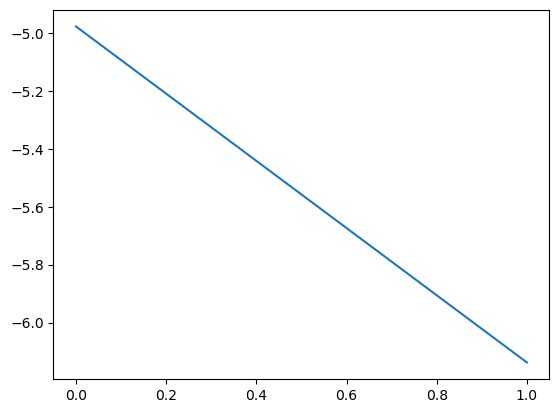

<Figure size 640x480 with 0 Axes>

In [172]:
import numpy as np
import matplotlib.pyplot as plt
e = np.array(e_list)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(len(e)), e)
plt.show()
plt.savefig(r"H2-0.735.png", dpi=1000)